# Reinforcement Learning Final Project 

Welcome to your Reinforcement Learning project! Join in groups of a maximum of 5 students on a project focused on developing an RL agent capable of solving an environment for decision-making in Autonomous Driving. The project deadline has been set to the 2nd of June.

Autonomous Driving has long been considered a field in which RL algorithms excel, and this project aims to leverage the power of RL to create an intelligent agent that can solve the Farama’s foundation “highway-env” project, namely the Highway environment (refer to https://highway-env.farama.org/environments/highway/).

## Project Requirements:

* The environments observation’s format can vary according to our preference, namely Kinematics, Grayscale Image, Occupancy grid and Time to collision (refer to https://highway-env.farama.org/observations/). In your solutions you should use 2 of these types.
* The agents actions can also vary, as continuous actions, discrete actions and discrete meta-actions (refer to https://highway-env.farama.org/actions/). In your solutions you should use 2 of these types.
* As for the algorithms to use, any algorithm is valid (seen or not in class), with a minimum requirement of 3 different algorithms used.
* Apart from the environment observation types and agent action types you must use environment’s configuration provided in the annexed notebook!
Note: Your delivery should comprise 4 solutions to the highway environment (corresponding to the combinations of the two environment observation’s types and the two agent’s action types), in which you just need to use one algorithm for each combination (knowing that you need to use at least 3 different algorithms).


## Project Objectives:

* Train an RL agent to solve the Highway environment: The primary objective of this project is to develop an RL agent that can maximize the reward given by the highway environment (refer to https://highway-env.farama.org/rewards/), which leverages to maximize speed while minimizing crash risk! 
* Optimize decision-making using RL algorithms: Explore different RL algorithms to train the agent. Compare and analyse their effectiveness in learning and decision-making capabilities in the context of the environment.
* Explore and expand on the reward system: Although you should evaluate your agent with the reward function provided by the environment, you could/should expand it to better train your agent.
* Enhance interpretability and analysis: Develop methods to analyse the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.



### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.
* Explore multi agent approaches: The environment allows you to use more than one agent per episode. Explore multi agent alternatives to improve your learning times and overall benchmarks.


## Imports Required

You might need to restart the kernel after installation

In [1]:
# ! pip install highway-env 

In [2]:
import gymnasium as gym

import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import pickle

## Environment Configuration

Apart from the environment observation types and agent action types you must use some of the environment’s configurations provided bellow!

In [3]:
configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    # "collision_reward": -10,  # The reward received when colliding with a vehicle. (Can be changed)
    # "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15,  # [Hz] (Can be changed)
    "policy_frequency": 5,  # [Hz] (Can be changed)

    "collision_reward": -1000,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.1,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 5,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,  # The reward received at each lane change action.
    "reward_speed_range": [20, 30],
    
    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

### Example Solution
### Solution 0
Environment Observation Type: **Kinematics** \
Agent Action Type: **DiscreteMetaAction** \
Algorithm Used: **Random**

Example of the environment's usage using a random policy.

In [4]:
env = gym.make('highway-v0', render_mode='human', config=configuration)

obs, info = env.reset(seed=42)
done = truncated = False

Return = 0
n_steps = 1
Episode = 0
while not (done or truncated):
  # Dispatch the observations to the model to get the tuple of actions
  action = env.action_space.sample()
  # Execute the actions
  next_obs, reward, done, truncated, info = env.step(action)
  Return+=reward

  print('Episode: {}, Step: {}, Return: {}'.format(Episode, n_steps, round(Return,2)))
  n_steps+=1
env.close()

Episode: 0, Step: 1, Return: 1.0
Episode: 0, Step: 2, Return: 1.99
Episode: 0, Step: 3, Return: 2.99
Episode: 0, Step: 4, Return: 3.99
Episode: 0, Step: 5, Return: 4.99
Episode: 0, Step: 6, Return: 5.99
Episode: 0, Step: 7, Return: 6.99
Episode: 0, Step: 8, Return: 7.98
Episode: 0, Step: 9, Return: 8.98
Episode: 0, Step: 10, Return: 9.98
Episode: 0, Step: 11, Return: 10.97
Episode: 0, Step: 12, Return: 11.97
Episode: 0, Step: 13, Return: 12.97
Episode: 0, Step: 14, Return: 13.97
Episode: 0, Step: 15, Return: 14.97
Episode: 0, Step: 16, Return: 15.97
Episode: 0, Step: 17, Return: 16.97
Episode: 0, Step: 18, Return: 17.97
Episode: 0, Step: 19, Return: 18.97
Episode: 0, Step: 20, Return: 19.96
Episode: 0, Step: 21, Return: 20.96
Episode: 0, Step: 22, Return: 21.96
Episode: 0, Step: 23, Return: 22.96
Episode: 0, Step: 24, Return: 23.96
Episode: 0, Step: 25, Return: 24.96
Episode: 0, Step: 26, Return: 25.96
Episode: 0, Step: 27, Return: 26.95
Episode: 0, Step: 28, Return: 27.95
Episode: 0, 

### Solution 1
Environment Observation Type: **Kinematics** \
Agent Action Type: **DiscreteMetaAction** \
Algorithm Used: **???**

How observation on each step looks like for Kinematics

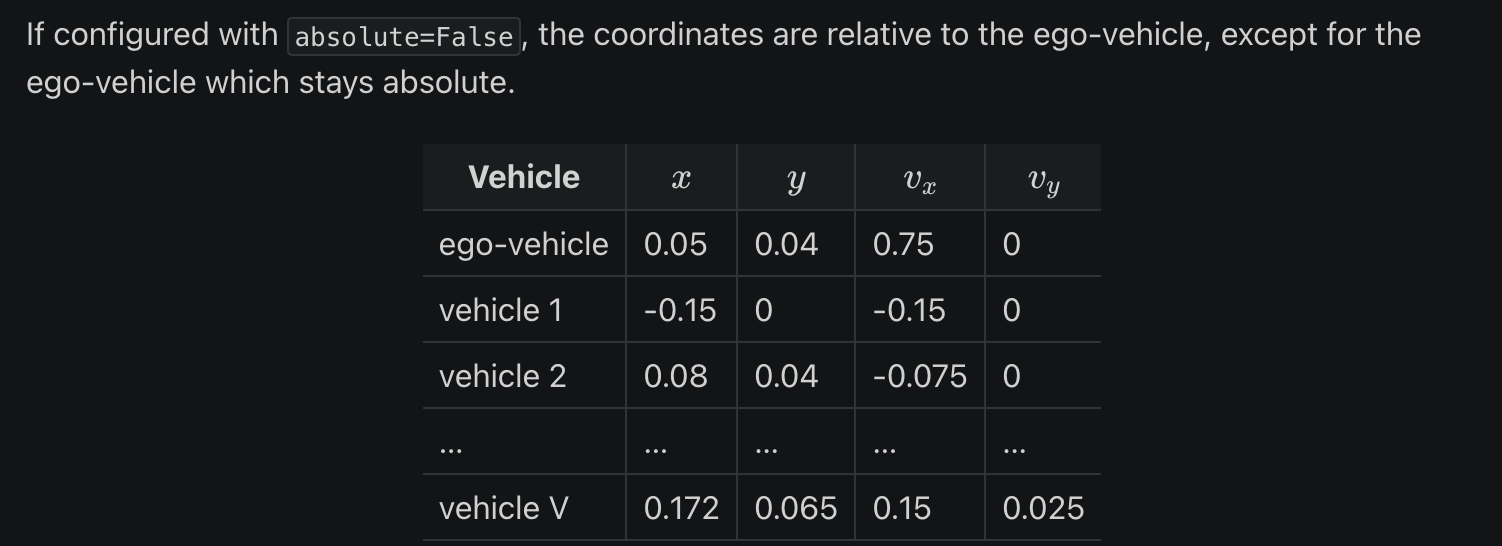

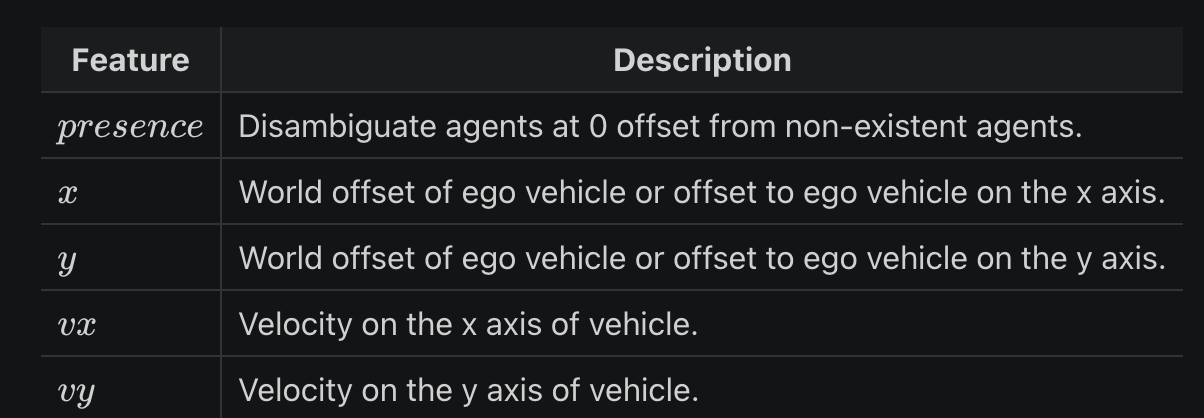

In [3]:
configuration["observation"] =  {
    "type": "OccupancyGrid",
    "vehicles_count": 50,
    "features": ["presence"],
                #  "x", "y", "vx", "vy"],
    # "features_range": {
    #     "x": [-100, 100],
    #     "y": [-100, 100],
    #     "vx": [-20, 20],
    #     "vy": [-20, 20]
    # },
    # "grid_size": [[-22.5, 22.5], [-22.5, 22.5]],  
    # "grid_step": [5, 5],

    "grid_size": [[-47.5, 47.5], [-47.5, 47.5]],
    "grid_step": [5, 5],
    "absolute": False,
    # "align_to_vehicle_axes" : True
}

In [5]:
configuration

{'lanes_count': 10,
 'vehicles_count': 50,
 'duration': 120,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'initial_spacing': 2,
 'observation': {'type': 'OccupancyGrid',
  'vehicles_count': 50,
  'features': ['presence'],
  'grid_size': [[-47.5, 47.5], [-47.5, 47.5]],
  'grid_step': [5, 5],
  'absolute': False},
 'action': {'type': 'DiscreteMetaAction'},
 'collision_reward': -10,
 'reward_speed_range': [20, 30],
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'screen_width': 800,
 'screen_height': 600,
 'centering_position': [0.5, 0.5],
 'scaling': 5,
 'show_trajectories': True,
 'render_agent': True,
 'offscreen_rendering': False}

In [6]:
env = gym.make('highway-v0', 
               render_mode='human', 
               config=configuration)

In [8]:
obs, info = env.reset(seed = 30)

env.close()

In [9]:
obs

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [10]:
slice_pos = 9

obs[0][slice_pos - 1:-(slice_pos - 1), slice_pos:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
info

{'speed': 25,
 'crashed': False,
 'action': 4,
 'rewards': {'collision_reward': 0.0,
  'right_lane_reward': 0.1111111111111111,
  'high_speed_reward': 0.5,
  'on_road_reward': 1.0}}

In [4]:
def reference_array(env, slice_pos = 2):
    obs, _ = env.reset(seed = 30)

    # Define the shape of the original array based on observation from env
    # We want to observe cars only to the right from slice position to simplify Q_table
    rows, cols = obs[0][slice_pos - 1:-(slice_pos - 1), slice_pos:].shape

    # Generate all possible combinations of 1s and 0s for a row of length `cols`
    combinations = list(itertools.product([0, 1], repeat=cols))

    # Create an array with shape (number of combinations, rows, cols)
    all_combinations_array = np.array(list(itertools.product(combinations, repeat=rows)))

    # Reshape it to the desired shape (num_combinations, rows, cols)
    num_combinations = len(combinations)**rows
    
    final_array = all_combinations_array.reshape((num_combinations, rows, cols))

    return final_array


In [5]:
def epsilon_greedy_policy(env, state, Q_table, epsilon=.5):
    
    #sample a random value from the uniform distribution, if the sampled value is less than
    #epsilon then we select a random action else we select the best action which has maximum Q
    #value as shown below
    
    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

In [6]:
def Q_LEARNING_STEP(env, final_array, slice_pos, action, current_q_value, discrete_state, Q_table, alpha, gamma, epsilon):

    # perform the selected action and store the next state information: 
    next_state, r, truncated, done, _ = env.step(action)

    # Verify if episode is over
    Done = done | truncated

    if Done:
        return 0, 0, 0, r, Done

    index_next_state = np.min(np.min(final_array == next_state[0][slice_pos - 1:-(slice_pos - 1), slice_pos:], axis = 1), axis = 1).argmax()
    
    # select the action a dash in the next state using the epsilon greedy policy:
    next_action = epsilon_greedy_policy(env, index_next_state, Q_table, epsilon=epsilon) 

    # compute the Q value of the next state-action pair
    
    next_q_value = Q_table[index_next_state][next_action]

    #In SARSA we use the next_q_value
    max_future_q_value = np.max(Q_table[index_next_state])

    # Calculate the new Q value
    new_q_value = current_q_value + alpha*(r + gamma*max_future_q_value - current_q_value)

    # update the new Q value
    Q_table[discrete_state][action] = new_q_value
    
    # update next state to current state
    discrete_state = index_next_state
    
    # update next action to current action
    action = next_action
    
    # update the next q_value to current q value
    current_q_value = next_q_value

    return action, current_q_value, discrete_state, r, Done

In [7]:
file_name = 'Q_LEARNING_Q_table_1000iter.pkl'

# Open the file in read-binary mode and unpickle the array
with open(file_name, 'rb') as file:
    Q_table = pickle.load(file)

print("Loaded array:")
print(Q_table)


Loaded array:
[[0.58256204 0.07217975 0.37519682 0.74551373 0.14175625]
 [0.8468635  0.81446168 0.6148236  0.71071002 0.79846338]
 [0.6272983  0.91560056 0.35879356 0.14776412 0.67207962]
 ...
 [0.62079299 0.00310268 0.69089248 0.29031674 0.53395738]
 [0.15794018 0.05973754 0.10708071 0.61807076 0.79445387]
 [0.50442293 0.86890361 0.27314647 0.85610328 0.62431179]]


In [42]:
def TD_control(env, slice_pos, STEP_FUNCTION, num_iteractions=100, alpha=.85, gamma=.9, Q_table_input=None):

    # Store the respective return for each episode
    RETURN_LIST = []

    states_visited = {}

    # We introduce EPSILON Decay, a way to progressively decrease exploration to explotion
    EPSILON = 0.8
    EPSILON_DECAY = EPSILON / num_iteractions
    
    final_array = reference_array(env, slice_pos=slice_pos)
    # Initialize Q Table
    if Q_table_input is None:
        # Q_table = np.random.random((final_array.shape[0], env.action_space.n))
        Q_table = np.zeros((final_array.shape[0], env.action_space.n))
    else:
        Q_table = Q_table_input

    print('Q_table shape: ', Q_table.shape)

    # for each episode
    for i in tqdm(range(num_iteractions)):
        
        # Define first state
        discrete_state = np.min(np.min(final_array == env.reset(seed = np.random.randint(100))[0][0][slice_pos - 1:-(slice_pos - 1), slice_pos:], axis = 1), axis = 1).argmax()
        
        # select the action using the epsilon-greedy policy
        action = epsilon_greedy_policy(env, discrete_state, Q_table, EPSILON)
        
        # select the current q_value
        current_q_value = Q_table[discrete_state][action]

        # Start Calculating each episode's return
        CUMULATIVE_REWARD = 0

        # Tracking when the episode is over
        Done = False

        # Tracking number of steps per episode
        STEP = 0

        #for each step in the episode:
        while not Done:
            
            # Run 
            action, current_q_value, discrete_state, r, Done = STEP_FUNCTION(env, 
                                                                             final_array, 
                                                                             slice_pos, 
                                                                             action, 
                                                                             current_q_value, 
                                                                             discrete_state, 
                                                                             Q_table, alpha, gamma, EPSILON)

            # Store step-wise metrics
            CUMULATIVE_REWARD += r
            STEP += 1

            if discrete_state not in states_visited.keys():
                states_visited[discrete_state] = 1
            else:
                states_visited[discrete_state] += 1

            # if the current state is the terminal state then break:
            if Done:
                break
        
        print(CUMULATIVE_REWARD, STEP)

        print(r)
        
        # Store episode-wise metrics
        RETURN_LIST.append([i, STEP, CUMULATIVE_REWARD])

        # Update EPSILON to acccount for decay
        EPSILON -= EPSILON_DECAY


    # Metrics to benchmark learning process
    return_df = pd.DataFrame(RETURN_LIST, columns=['Episode', 'N_Steps', 'Return'])
                             
    return Q_table, return_df, states_visited

In [64]:
env.reset()

(array([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 1,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 1.0,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [66]:
configuration["observation"] =  {
    "type": "OccupancyGrid",
    "features": ["presence"],
    "grid_size": [[-45, 45], [-45, 45]],
    "grid_step": [10, 10],
    "absolute": False
}

env = gym.make('highway-v0', 
            #    render_mode='human', 
               config=configuration)

Q_LEARNING_Q_table, Q_LEARNING_return_df, states_visited = TD_control(env, 4, Q_LEARNING_STEP, num_iteractions = 500, alpha=.1, 
                                                                      gamma=.9,
                                                                    #   Q_table_input=Q_table
                                                                      )

env.close()

Q_table shape:  (32768, 5)


  0%|          | 0/500 [00:00<?, ?it/s]

39.85805700510311 41
0.0005523929322206665
171.37201473883025 173
0.004602930814368205
24.94199682825433 26
0.004028036159410198
97.69961243748521 99
0.0019528239725079056
102.68602479615102 104
0.001631888882962599
17.940595980999213 19
0.0024417932635227057
117.59493541741317 119
0.0019819687440041454
15.956150549390268 17
4.421892791212796e-05
37.882812106115445 39
0.002531996566163659
14.950514358684067 16
0.002312071695476915
22.920631632864726 24
0.0038238053607575003
132.53019631966256 134
0.0026965777717642267
23.97602221363313 25
0.004406232209278829
99.70349616775874 101
3.3164195934039416e-05
8.977831553559685 10
0.0012397950982900186
8.975164836267295 10
6.632839186819194e-05
80.78189167725847 82
0.003061103983151734
28.971195323715897 30
0.003418583687951981
71.85344693888054 73
0.0036958930132333194
8.98893364950197 10
0.003225897199882269
30.881119857350463 32
0.0020983888597322056
7.969153575442953 9
6.632839186819194e-05
22.94713640201964 24
0.0024072814813046093
17.98

How it works:

Each state has shape 3x5, which represent the cut from Occupacy grid. 

Grid parameters:

- "features": ["presence"], 
- "grid_size": [[-45, 45], [-45, 45]],
- "grid_step": [10, 10],
- "absolute": False

Afterwards each observation is cut by following schema:

slice_pos = 4

obs[0][slice_pos - 1:-(slice_pos - 1), slice_pos:] 

Meaning that we are only interested in a limited range around the car to the right and left and in the front. So the car itself is always located on the position [1][0] (first element of the second row)

Example of the state below

[[0, 0, 0, 0, 0],
[1, 0, 0, 1, 0],
[1, 1, 0, 1, 0]]

Training

- 500 iterations starting from epsilon 1 with decay to 0
- 500 more iterations starting from epsilon 0.8 with decay to 0

In [67]:
file_name = 'Q_LEARNING_Q_table_500iter_highfreq.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(Q_LEARNING_Q_table, file)

print(f"Array has been pickled to {file_name}")


Array has been pickled to Q_LEARNING_Q_table_500iter_highfreq.pkl


In [68]:
pd.Series(states_visited).sort_values()

17281       1
18179       1
18051       1
18049       1
2691        1
         ... 
560       704
513       724
642       748
544      1239
512      2883
Length: 1498, dtype: int64

In [69]:
final_array[528]


array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [70]:
Q_LEARNING_Q_table[528]

array([2.90136217, 3.1925814 , 1.95440831, 7.71478625, 2.70242177])

In [29]:
slice_pos = 4

final_array = reference_array(env, slice_pos=slice_pos)

test_array = np.array([[0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

index_next_state = np.min(np.min(final_array == test_array, axis = 1), axis = 1).argmax()

Q_LEARNING_Q_table[index_next_state]
    

array([3.71619127, 5.82255293, 4.38457656, 4.09952128, 4.39460562])

In [71]:
def visualize_run(env, Q_table, slice_pos):
    # No need for randomness
    EPSILON = 0

    CUMULATIVE_RETURN = 0

    final_array = reference_array(env, slice_pos = slice_pos)

    obs, info = env.reset(seed = np.random.randint(100))

    discrete_state = np.min(np.min(final_array == obs[0][slice_pos - 1:-(slice_pos - 1), slice_pos:], axis = 1), axis = 1).argmax()

    done = False
    
    while not done:
        
        env.render()

        # select the action a dash in the next state using the epsilon greedy policy:
        action = epsilon_greedy_policy(env, discrete_state, Q_table, epsilon=EPSILON) 

        # STEP
        continuous_state, r, truncated, done, _ = env.step(action)
        
        # Discrete state
        discrete_state = np.min(np.min(final_array == continuous_state[0][slice_pos - 1:-(slice_pos - 1), slice_pos:], axis = 1), axis = 1).argmax()

        CUMULATIVE_RETURN += r

        done = done or truncated

    env.close()

    return CUMULATIVE_RETURN

In [72]:
Q_LEARNING_Q_table

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [75]:
configuration["observation"] =  {
    "type": "OccupancyGrid",
    "features": ["presence"],
    "grid_size": [[-45, 45], [-45, 45]],
    "grid_step": [10, 10],
    "absolute": False
}

env = gym.make('highway-v0',  render_mode='human', config=configuration)

In [78]:
CUMULATIVE_RETURN = visualize_run(env, Q_LEARNING_Q_table,  4)

In [11]:
Q_table

array([[0.58256204, 0.07217975, 0.37519682, 0.74551373, 0.14175625],
       [0.8468635 , 0.81446168, 0.6148236 , 0.71071002, 0.79846338],
       [0.6272983 , 0.91560056, 0.35879356, 0.14776412, 0.67207962],
       ...,
       [0.62079299, 0.00310268, 0.69089248, 0.29031674, 0.53395738],
       [0.15794018, 0.05973754, 0.10708071, 0.61807076, 0.79445387],
       [0.50442293, 0.86890361, 0.27314647, 0.85610328, 0.62431179]])

In [1002]:
non_zero_rows = Q_LEARNING_Q_table[np.any(Q_LEARNING_Q_table != 0, axis=1)]
non_zero_rows.shape

(497, 5)

<Axes: xlabel='Episode'>

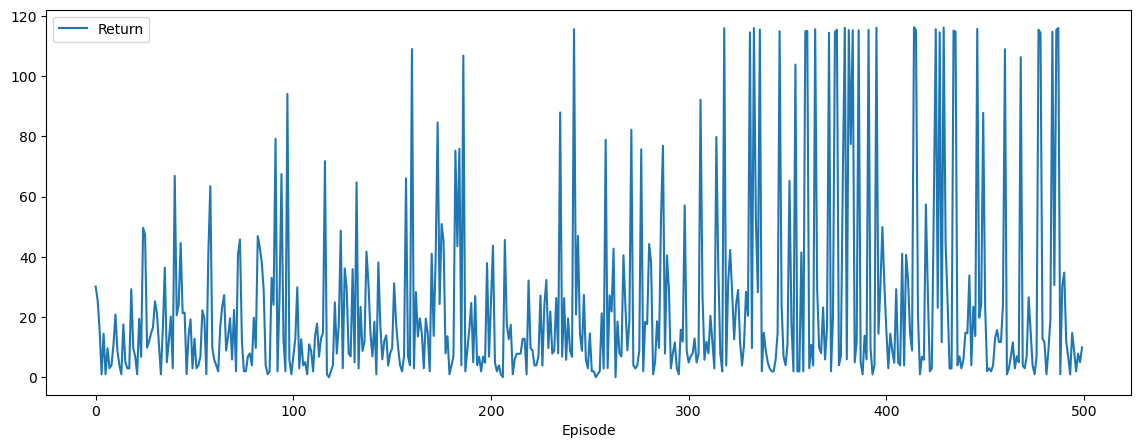

In [27]:
Q_LEARNING_return_df.plot(x='Episode', y='Return', figsize=(14, 5))

In [77]:
env = gym.make('highway-v0', render_mode='human', config=configuration)

obs, info = env.reset(seed=42)
done = truncated = False

Return = 0
n_steps = 1
Episode = 0
while not (done or truncated):
  # Dispatch the observations to the model to get the tuple of actions
  action = env.action_space.sample()
  # Execute the actions
  next_obs, reward, done, truncated, info = env.step(action)
  Return+=reward

  print('Episode: {}, Step: {}, Return: {}'.format(Episode, n_steps, round(Return,2)))
  n_steps+=1
env.close()

Episode: 0, Step: 1, Return: 0.0
Episode: 0, Step: 2, Return: 0.0
Episode: 0, Step: 3, Return: 0.0
Episode: 0, Step: 4, Return: 0.0
Episode: 0, Step: 5, Return: 0.0
Episode: 0, Step: 6, Return: 0.0
Episode: 0, Step: 7, Return: 0.0


KeyboardInterrupt: 

### Solution 2
Environment Observation Type: \
Agent Action Type: \
Algorithm Used: 

In [ ]:
configuration['action']['type'] = 'ContinuousAction'
dict_ttc = {
        "type": "TimeToCollision",
        "horizon": 5,  # Maximum number of time steps to consider
    }
configuration["observation"] = dict_ttc

## Solution 3
Environment Observation Type: \
Agent Action Type: \
Algorithm Used: 

## Solution 4
Environment Observation Type: \
Agent Action Type: \
Algorithm Used: 